This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks). 

## BOLFI

In practice inference problems often have a complicated and computationally heavy simulator, and one simply cannot run it for millions of times. The Bayesian Optimization for Likelihood-Free Inference [BOLFI](http://jmlr.csail.mit.edu/papers/v17/15-017.html) framework is likely to prove useful in such situation: a statistical model (usually [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process), GP) is created for the discrepancy, and its minimum is inferred with [Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization). This approach typically reduces the number of required simulator calls by several orders of magnitude.

This tutorial demonstrates how to use BOLFI to do LFI in ELFI.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%precision 2

import logging
logging.basicConfig(level=logging.INFO)

# Set an arbitrary global seed to keep the randomly generated quantities the same
seed = 20170703
np.random.seed(seed)

import elfi

Although BOLFI is best used with complicated simulators, for demonstration purposes we will use the familiar MA2 model introduced in the basic tutorial, and load it from ready-made examples:

In [2]:
# from elfi.examples import gauss
# model = gauss.get_model(seed_obs=seed)

# from elfi.examples import gauss_fixedvar
# model = gauss_fixedvar.get_model(seed_obs=seed)

# from elfi.examples import gauss_fixedvar_2d
# model = gauss_fixedvar_2d.get_model(seed_obs=seed)

from elfi.examples import ma2
model = ma2.get_model(seed_obs=seed)

# from elfi.examples import ricker as rckr
# model = rckr.get_model(seed_obs=seed)

### Fitting the surrogate model

Now we can immediately proceed with the inference. However, when dealing with a Gaussian process, it may be beneficial to take a logarithm of the discrepancies in order to reduce the effect that high discrepancies have on the GP. (Sometimes you may want to add a small constant to avoid very negative or even -Inf distances occurring especially if it is likely that there can be exact matches between simulated and observed data.) In ELFI such transformed node can be created easily:

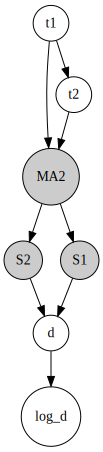

In [3]:
log_d = elfi.Operation(np.log, model['d'])
elfi.draw(log_d)

As BOLFI is a more advanced inference method, its interface is also a bit more involved as compared to for example rejection sampling. But not much: Using the same graphical model as earlier, the inference could begin by defining a Gaussian process (GP) model, for which ELFI uses the [GPy](https://sheffieldml.github.io/GPy/) library. This could be given as an `elfi.GPyRegression` object via the keyword argument `target_model`. In this case, we are happy with the default that ELFI creates for us when we just give it each parameter some `bounds` as a dictionary.

Other notable arguments include the `initial_evidence`, which gives the number of initialization points sampled straight from the priors before starting to optimize the acquisition of points, `update_interval` which defines how often the GP hyperparameters are optimized, and `acq_noise_var` which defines the diagonal covariance of noise added to the acquired points.

In [5]:
# The fixed var Gaussian model
# bolfi = elfi.BOLFI(log_d, batch_size=5, initial_evidence=20, update_interval=10, 
#                    bounds={'mu':(-10, 40)}, acq_noise_var=[0.1, 0.1],
#                    seed=seed)

# The fixed var Gaussian model
# bolfi = elfi.BOLFI(log_d, batch_size=5, initial_evidence=20, update_interval=10, 
#                    bounds={'mu':(-2, 2)}, acq_noise_var=[0.1, 0.1],
#                    seed=seed, acquisition_method='exp_int_var')

# The 2-D Gaussian model
# bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=10, update_interval=10, 
#                    bounds={'mu1':(0, 10), 'mu2':(0, 10)}, 
#                    seed=seed, acquisition_method='max_var_rand')
#                    seed=seed, acquisition_method='max_var')
# The MA2 model
# bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=10, update_interval=10, 
#                    bounds={'t1':(0, 2), 't2':(0, 2)}, seed=seed, acquisition_method='exp_int_var')

bolfi = elfi.BOLFI(log_d, batch_size=5, initial_evidence=10, update_interval=10, 
                   bounds={'t1':(0, 2), 't2':(0, 2)}, seed=seed)

# The Ricker model
# bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=10, update_interval=10, 
#                    bounds={'t1':(np.e, np.e+2), 't2':(0, 5), 't3':(0, 100)}, seed=seed)


Sometimes you may have some samples readily available. You could then initialize the GP model with a dictionary of previous results by giving `initial_evidence=result.outputs`.

The BOLFI class can now try to `fit` the surrogate model (the GP) to the relationship between parameter values and the resulting discrepancies. We'll request only 100 evidence points (including the `initial_evidence` defined above).

In [6]:
%time post = bolfi.fit(n_evidence=20)

INFO:elfi.methods.parameter_inference:BOLFI: Fitting the surrogate model...
INFO:elfi.methods.parameter_inference:Submitting batch 0
INFO:elfi.methods.parameter_inference:Received batch 0
INFO:elfi.methods.parameter_inference:Submitting batch 1
INFO:elfi.methods.parameter_inference:Received batch 1
INFO:elfi.methods.parameter_inference:Submitting batch 2
INFO:elfi.methods.parameter_inference:Received batch 2
INFO:elfi.methods.parameter_inference:Submitting batch 3
INFO:elfi.methods.parameter_inference:Received batch 3
INFO:elfi.methods.posteriors:Using optimized minimum value (-0.7584) of the GP discrepancy mean function as a threshold


CPU times: user 1.83 s, sys: 57.7 ms, total: 1.89 s
Wall time: 2.1 s


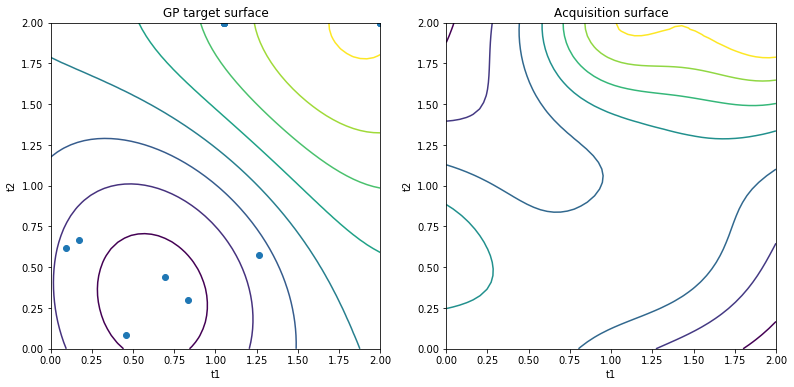

In [7]:
bolfi.plot_state()

In [ ]:
bolfi.target_model

It may be useful to see the acquired parameter values and the resulting discrepancies:

In [ ]:
bolfi.plot_discrepancy();

There could be an unnecessarily high number of points at parameter bounds. These could probably be decreased by lowering the covariance of the noise added to acquired points, defined by the optional `acq_noise_var` argument for the BOLFI constructor. Another possibility could be to [add virtual derivative observations at the borders](https://arxiv.org/abs/1704.00963), though not yet implemented in ELFI.

### BOLFI Posterior

Above, the `fit` method returned a `BolfiPosterior` object representing a BOLFI posterior (please see the [paper](http://jmlr.csail.mit.edu/papers/v17/15-017.html) for details). The `fit` method accepts a threshold parameter; if none is given, ELFI will use the minimum value of discrepancy estimate mean. Afterwards, one may request for a posterior with a different threshold:

In [ ]:
post2 = bolfi.extract_posterior(-1.)

One can visualize a posterior directly (remember that the priors form a triangle):

In [ ]:
post.plot(logpdf=False)

In [ ]:
post.plot(logpdf=False)

### Sampling

Finally, samples from the posterior can be acquired with an MCMC sampler. By default it runs 4 chains, and half of the requested samples are spent in adaptation/warmup. Note that depending on the smoothness of the GP approximation, the number of priors, their gradients etc., this may be slow.

In [ ]:
%time result_BOLFI = bolfi.sample(200, info_freq=1000)

The sampling algorithms may be fine-tuned with some parameters. The default [No-U-Turn-Sampler](http://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf) is a sophisticated algorithm, and in some cases one may get warnings about diverged proposals, which are signs that [something may be wrong and should be investigated](http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup). It is good to understand the cause of these warnings although they don't automatically mean that the results are unreliable. You could try rerunning the `sample` method with a higher target probability `target_prob` during adaptation, as its default 0.6 may be inadequate for a non-smooth posteriors, but this will slow down the sampling. 

Note also that since MCMC proposals outside the region allowed by either the model priors or GP bounds are rejected, a tight domain may lead to suboptimal overall acceptance ratio. In our MA2 case the prior defines a triangle-shaped uniform support for the posterior, making it a good example of a difficult model for the NUTS algorithm.

Now we finally have a `Sample` object again, which has several convenience methods:

In [ ]:
result_BOLFI

In [ ]:
result_BOLFI

In [ ]:
result_BOLFI.plot_traces();

The black vertical lines indicate the end of warmup, which by default is half of the number of iterations.

In [ ]:
result_BOLFI.plot_marginals();

In [ ]:
result_BOLFI.plot_pairs();